<a href="https://colab.research.google.com/github/kmayutrisna/IMDB_CNN_biLSTM/blob/main/SA_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

In [9]:
! pip install -q kaggle

In [10]:
from google.colab import files

In [12]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chamomilemint","key":"aaf96cf1bd79a03b1ccdd84ea1390c43"}'}

In [14]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [15]:
! cp kaggle.json ~/.kaggle/

In [16]:
! chmod 600 ~/.kaggle/kaggle.json

In [17]:
! kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 35% 9.00M/25.7M [00:00<00:00, 94.0MB/s]
100% 25.7M/25.7M [00:00<00:00, 167MB/s] 


In [18]:
! unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [19]:
data = pd.read_csv('IMDB Dataset.csv')


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive




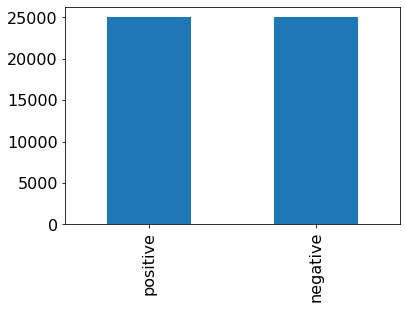

In [20]:
# display the first 5 rows of data
print()
print(data.head(5))

print('\n')
plt.figure(figsize = (6,4))
data['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

Positive review:  One of the more lucid statements against the death penalty ever filmed, quite a frontal attack against the most disgusting way of doing justice. The final sequence, with that parallel between the crimes that the convicted Poncelet committed and his own execution are just superb.<br /><br />No, what about the work of Sean Penn and Susan Sarandon? It leaves you breathless, they're two giants and their performances achieve the highest levels of emotion.<br /><br />Tim Robbins put clear that he's not only a good actor, he's a nice director as well.<br /><br />*My rate: 9/10


Negative review:  Mary Lou is a slut whose spirit seeks revenge on those who let her come to her fiery doom back in 1957.<br /><br />Well, the movie mainly takes place in 1986. The movie falls into the 80's trap of weird/stupid special effects, including some weird demented looking rocking horse.<br /><br />Anyway, Mary Lou's spirit does bad things to people and tries to take over one person's body. 

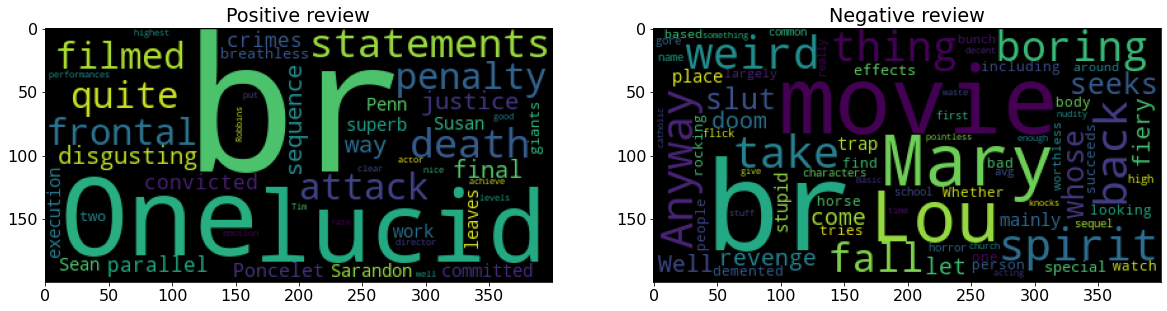

In [21]:
# Choose randomly a positive review and a negative review
ind_positive = random.choice(list(data[data['sentiment'] == 'positive'].index))
ind_negative = random.choice(list(data[data['sentiment'] == 'negative'].index))

review_positive = data['review'][ind_positive]
review_negative = data['review'][ind_negative]

print('Positive review: ', review_positive)
print('\n')
print('Negative review: ', review_negative)
print('\n')

from wordcloud import WordCloud
cloud_positive = WordCloud().generate(review_positive)
cloud_negative = WordCloud().generate(review_negative)

plt.figure(figsize = (20,15))
plt.subplot(1,2,1)
plt.imshow(cloud_positive)
plt.title('Positive review')

plt.subplot(1,2,2)
plt.imshow(cloud_negative)
plt.title('Negative review')
plt.show()

In [22]:
#Text Cleaning
import re

def remove_url(text):
    url_tag = re.compile(r'https://\S+|www\.\S+')
    text = url_tag.sub(r'', text)
    return text

def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    text = html_tag.sub(r'', text)
    return text

def remove_punctuation(text): 
    punct_tag = re.compile(r'[^\w\s]')
    text = punct_tag.sub(r'', text) 
    return text

def remove_special_character(text):
    special_tag = re.compile(r'[^a-zA-Z0-9\s]')
    text = special_tag.sub(r'', text)
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text    
    
def clean_text(text):
    text = remove_url(text)
    text = remove_html(text)
    text = remove_punctuation(text)
    text = remove_special_character(text)
    text = remove_emojis(text)
    text = text.lower()
    
    return text

In [23]:
data['processed'] = data['review'].apply(lambda x: clean_text(x))
data.head()

,review,sentiment,processed
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


In [24]:
#Data Processing
data['Label'] = data['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)

data_0 = data[data['Label'] == 0]
data_1 = data[data['Label'] == 1]

train_size = int(0.7*25000)
val_size = int(0.2*25000)

data_train = pd.concat((data_0[:train_size], data_1[:train_size]), axis = 0)
data_val = pd.concat((data_0[train_size: (train_size + val_size)], data_1[train_size:(train_size + val_size)]), axis = 0)
data_test = pd.concat((data_0[(train_size + val_size):], data_1[(train_size + val_size):]), axis = 0)

X_train, y_train = list(data_train['processed']), np.array(data_train['Label'])
X_val, y_val = list(data_val['processed']), np.array(data_val['Label'])
X_test, y_test = list(data_test['processed']), np.array(data_test['Label'])

print('Train size:', len(X_train))
print('Validation size: ', len(X_val))
print('Test size: ', len(X_test))

Train size: 35000
Validation size:  10000
Test size:  5000


In [25]:
vocab_size = 10000
max_length = 500
trunc_type = 'post'
oov_tok = 'OOV'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
token = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
token.fit_on_texts(X_train)
index_word = token.index_word

# Convert texts to sequences
train_seq = token.texts_to_sequences(X_train)
val_seq = token.texts_to_sequences(X_val)
test_seq = token.texts_to_sequences(X_test)

# Sequence padding
#Since the sequences have different lengtht, then we use padding method to put all sequences to the same length. 
#The parameter "maxlen" sets the maximum length of the output sequence. 
#    + If length of the input sequence is larger than "maxlen", then it is trunced to keep only #maxlen words, (truncating = 'pre': keep the previous part of the sequence; truncating = 'post': keep the posterior part of the sequence).
#    + If length of the input sequence is smaller than "maxlen", then 0 elements will be padded into the previous part of sequence (if padding = 'pre' - by defaut) or in the tail of the sequence (if padding = 'post').

train_pad = pad_sequences(train_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)
val_pad = pad_sequences(val_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)
test_pad = pad_sequences(test_seq, maxlen = max_length, padding = 'post', truncating = trunc_type)

In [26]:
# Shuffle the training set
p = np.random.permutation(len(train_pad))
train_pad = train_pad[p]
y_train = y_train[p]

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, AveragePooling1D, Bidirectional, LSTM, Dense
from tensorflow.keras.utils import plot_model

embedding_dim = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(AveragePooling1D(pool_size = 2))
model.add(Bidirectional(LSTM(200, dropout = 0.5)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

plot_model(model, show_shapes = True)

H = model.fit(train_pad, y_train, epochs = 10, batch_size = 128,
             validation_data = (val_pad, y_val) )

Epoch 1/10
274/274 [==============================] - 906s 3s/step - loss: 0.5205 - accuracy: 0.7174 - val_loss: 0.3507 - val_accuracy: 0.8634
Epoch 2/10
274/274 [==============================] - 931s 3s/step - loss: 0.4399 - accuracy: 0.7971 - val_loss: 0.3124 - val_accuracy: 0.8716
Epoch 3/10
274/274 [==============================] - 909s 3s/step - loss: 0.2478 - accuracy: 0.9045 - val_loss: 0.2999 - val_accuracy: 0.8746
Epoch 4/10
274/274 [==============================] - 783s 3s/step - loss: 0.1927 - accuracy: 0.9273 - val_loss: 0.2806 - val_accuracy: 0.8861
Epoch 5/10
274/274 [==============================] - 781s 3s/step - loss: 0.1604 - accuracy: 0.9428 - val_loss: 0.2997 - val_accuracy: 0.8918
Epoch 6/10
274/274 [==============================] - 781s 3s/step - loss: 0.1426 - accuracy: 0.9501 - val_loss: 0.3219 - val_accuracy: 0.8791
Epoch 7/10
274/274 [==============================] - 778s 3s/step - loss: 0.1242 - accuracy: 0.9578 - val_loss: 0.3270 - val_accuracy: 0.8813

# New section